In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [85]:
data_train = pd.read_csv('yelp_academic_dataset_review_train.csv')
data_test = pd.read_csv('yelp_academic_dataset_review_test.csv')
train_biz = pd.read_csv("yelp_academic_dataset_business_train.csv")
test_biz = pd.read_csv("yelp_academic_dataset_business_test.csv")

In [86]:
all_reviews = pd.concat([data_train.text, data_test.text])
train_length = data_train.shape[0]
test_length = data_test.shape[0]

In [123]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LogisticRegression, LinearRegression, LassoCV

In [6]:
np.random.seed(154)

In [7]:
train_biz[['business_id', 'stars']].set_index("business_id").to_csv("Biz_Stars")

# Sentiment Analysis

### Start by balancing the classes

In [8]:
rating_4 = np.array(data_train[data_train.stars == 4].index)
rating_5 = np.array(data_train[data_train.stars == 5].index)
np.random.shuffle(rating_4)
np.random.shuffle(rating_5)
rating_4 = rating_4[:len(rating_4)//2]
rating_5 = rating_5[:2*len(rating_5)//3]
data_train_balanced = data_train.drop(rating_4)
data_train_balanced = data_train.drop(rating_5)

### Then use bag of words

In [14]:
count_vect = CountVectorizer(stop_words='english')
count_vect.fit(data_train_balanced.text)
X_train_counts = count_vect.transform(data_train.text)
X_test_counts = count_vect.transform(data_test.text)

In [10]:
np.savetxt("matrix.csv", X_train_counts.todense(), delimiter=",")

### Then SVD

In [11]:
feature_selector = TruncatedSVD(n_components=100)
X_train_best = feature_selector.fit_transform(X_train_counts, data_train.stars)

### Then classify

In [11]:
clfr = RandomForestClassifier(verbose=1, n_estimators=30, n_jobs=-1, max_depth=10, max_features=20)
clfl = LogisticRegression(C=100000.0, class_weight=None, dual=False,
                        fit_intercept=True, intercept_scaling=1, max_iter=100,
                        multi_class='ovr', penalty='l2', random_state=None,
                        solver='liblinear', tol=0.0001, verbose=2)

In [34]:
clf = clfl
cv_preds = cross_val_predict(clf, X_train_counts, data_train.stars, cv=10)
data_train['cv_preds'] = cv_preds
grouped = data_train.groupby("business_id").mean()
compare = train_biz.merge(grouped, left_on='business_id', right_index=True)
np.sqrt(np.mean((compare.stars_x - compare.cv_preds)**2))

0.39578698833827292

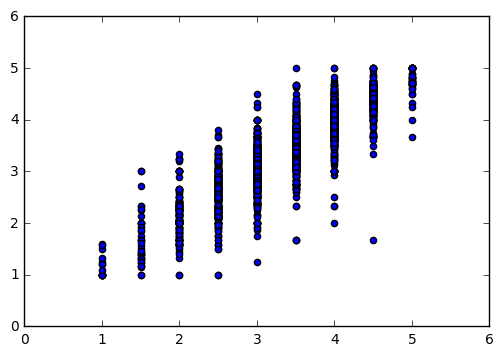

In [36]:
plt.scatter(compare.stars_x, compare.cv_preds)

## Trying Doc2Vec

In [32]:
import gensim
model = gensim.models.doc2vec.Doc2Vec(min_count=1, window=10, size=1000, sample=1e-4, negative=5, workers=4, iter=10)
print("Preprocessing data")

train_reviews = []
for i, review in enumerate(data_train.text):
    if i % 10000 == 0 and i != 0:
        print(i)
    preprocessed = gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(review), [i])
    train_reviews.append(preprocessed)
    
test_reviews = []
for review in data_test.text:
    if i % 10000 == 0 and i != 0:
        print(i)
    preprocessed = gensim.utils.simple_preprocess(review)
    test_reviews.append(preprocessed)    
    
print("Building Vocab")

model = gensim.models.doc2vec.Doc2Vec.load("Doc2Vec/Doc2VecModel")

print("Inferring Vectors")
X_train = np.array([model.infer_vector(review.words) for review in train_reviews])
X_test = np.array([model.infer_vector(review) for review in test_reviews])

Preprocessing data
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
Building Vocab
Inferring Vectors


In [33]:
clfr = RandomForestClassifier(verbose=2, n_estimators=20, n_jobs=-1, max_depth=10, max_features=20)
clfl = LogisticRegression(C=100000.0, class_weight=None, dual=False,
                        fit_intercept=True, intercept_scaling=1, max_iter=100,
                        multi_class='ovr', penalty='l2', random_state=None,
                        solver='liblinear', tol=0.0001, verbose=2)

In [36]:
clf = clfr
cv_preds = cross_val_predict(clf, X_train, data_train.stars, cv=10)
data_train['cv_preds'] = cv_preds
grouped = data_train.groupby("business_id").mean()
compare = train_biz.merge(grouped, left_on='business_id', right_index=True)
np.sqrt(np.mean((compare.stars_x - compare.cv_preds)**2))

building tree 1 of 20
building tree 2 of 20building tree 3 of 20building tree 4 of 20


building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   17.8s finished
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


building tree 1 of 20building tree 2 of 20building tree 3 of 20building tree 4 of 20



building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   21.9s finished
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


building tree 4 of 20building tree 2 of 20
building tree 3 of 20building tree 1 of 20


building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   23.5s finished
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


building tree 2 of 20
building tree 1 of 20building tree 4 of 20building tree 3 of 20


building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   20.5s finished
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


building tree 1 of 20building tree 2 of 20building tree 3 of 20building tree 4 of 20



building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20building tree 14 of 20

building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   16.5s finished
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


building tree 2 of 20building tree 3 of 20
building tree 4 of 20building tree 1 of 20


building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   21.2s finished
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


building tree 1 of 20building tree 3 of 20building tree 4 of 20building tree 2 of 20



building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20building tree 18 of 20

building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   25.2s finished
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


building tree 2 of 20building tree 3 of 20building tree 4 of 20building tree 1 of 20



building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   23.1s finished
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


building tree 2 of 20building tree 3 of 20building tree 1 of 20building tree 4 of 20



building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   20.6s finished
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


building tree 2 of 20building tree 1 of 20building tree 3 of 20building tree 4 of 20



building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   21.4s finished
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


1.3413806794496599

# Other Features

In [28]:
def get_price_range(attributes):
    if type(attributes) == str and 'RestaurantsPriceRange2' in attributes:
        return int(attributes[attributes.index('RestaurantsPriceRange2')+24])
    return np.nan

def get_cred_info(attributes):
    if type(attributes) == str and 'BusinessAcceptsCreditCards' in attributes:
        index = attributes.index('BusinessAcceptsCreditCards')
        return True if attributes[index+28] == "T" else False
    return np.nan

def get_reservations(attributes):
    if type(attributes) == str and 'RestaurantsReservations' in attributes:
        index = attributes.index('RestaurantsReservations')
        return True if attributes[index+25] == "T" else False
    return np.nan

def get_takeout(attributes):
    if type(attributes) == str and 'RestaurantsTakeOut' in attributes:
        index = attributes.index('RestaurantsTakeOut')
        return True if attributes[index+20] == "T" else False
    return np.nan

def get_delivery(attributes):
    if type(attributes) == str and 'RestaurantsDelivery' in attributes:
        index = attributes.index('RestaurantsDelivery')
        return True if attributes[index+21] == "T" else False
    return np.nan

train_price_range = train_biz.attributes.apply(get_price_range)
test_price_range = test_biz.attributes.apply(get_price_range)
train_credit_cards = train_biz.attributes.apply(get_cred_info)
test_credit_cards = test_biz.attributes.apply(get_cred_info)
train_reservations = train_biz.attributes.apply(get_cred_info)
test_reservations = test_biz.attributes.apply(get_cred_info)
train_takeout = train_biz.attributes.apply(get_takeout)
test_takeout = test_biz.attributes.apply(get_takeout)
train_delivery = train_biz.attributes.apply(get_delivery)
test_delivery = test_biz.attributes.apply(get_delivery)

In [80]:
cv_preds = cross_val_predict(clf, X_train_counts, data_train.stars, cv=10)
data_train['preds'] = cv_preds
grouped = data_train.groupby("business_id").mean()
X_train = train_biz.merge(grouped, left_on='business_id', right_index=True)[["preds", "stars_y"]]
X_train, y_train = X_train.drop("stars_y", axis=1), X_train.stars_y

clf.fit(X_train_counts, data_train.stars)
data_test['preds'] = clf.predict(X_test_counts)
grouped = data_test.groupby("business_id").mean()
X_test = test_biz.merge(grouped, left_on='business_id', right_index=True)[["preds"]]
biz_ids = test_biz.merge(grouped, left_on='business_id', right_index=True).business_id

X_train['price_range'] = train_price_range
X_train['credit_cards'] = train_credit_cards
X_train['reservations'] = train_reservations
X_train['takeout'] = train_takeout
X_train['delivery'] = train_delivery

X_test['price_range'] = test_price_range
X_test['credit_cards'] = test_credit_cards
X_test['reservations'] = test_reservations
X_test['takeout'] = test_takeout
X_test['delivery'] = test_delivery

In [81]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

values = OneHotEncoder().fit_transform(LabelEncoder().fit_transform(test_biz.categories).reshape(-1,1)).todense()

for i, value in enumerate(values.T):
    X_test[i] = np.array(value.reshape(-1,1))
    
values = OneHotEncoder().fit_transform(LabelEncoder().fit_transform(train_biz.categories).reshape(-1,1)).todense()

for i, value in enumerate(values.T):
    X_train[i] = np.array(value.reshape(-1,1))

In [82]:
X_train = Imputer().fit_transform(X_train)
X_test = Imputer().fit_transform(X_test)

In [127]:
clf_2 = LassoCV()
clf_2.fit(X_train, y_train)
clf_2.predict(X_test)

cv_preds = cross_val_predict(clf_2, X_train, y_train, cv=10)
np.sqrt(np.mean((cv_preds - y_train)**2))

0.34875954451385011

In [40]:
final_df = pd.DataFrame({'business_id': biz_ids, 'score': clf_2.predict(X_test)})
merged = final_df.merge(test_biz, on="business_id")
merged = merged.set_index('business_id')
merged['stars'] = merged.score
merged[['stars']].to_csv("Sub")

# Feature Selection

# Other

In [ ]:
pred_df = pd.DataFrame([{"business_id": biz, "stars": pred_per_buisiness[biz]} for biz in test_biz.business_id])
pred_df = pred_df.set_index("business_id")
pred_df.to_csv("Submission")

In [ ]:
importances = [pair for pair in enumerate(clf.feature_importances_)]
sorted_importances = sorted(importances, key = lambda x: x[1], reverse=True)
top_ten = [x[0] for x in sorted_importances[:10]]
feature_lookup = {count_vect.vocabulary_[key]: key for key in count_vect.vocabulary_}
[feature_lookup[feature] for feature in top_ten]